In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time

from google.colab import files
import numpy as np
import pandas as pd
import itertools
import io
import timeit
import time

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#tf.config.run_functions_eagerly(True)

Check if the GPU is on

In [ ]:
#%tensorflow_version 2.x
#import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Access datasets

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1iknZspDiM285QuBXLT9sjuZ-bTOxN6Hm"})
downloaded.GetContentFile('dataset0.csv')
dataset0 = pd.read_csv('dataset0.csv')
dataset0.drop('Unnamed: 0', axis=1, inplace=True)

downloaded = drive.CreateFile({'id':"1SjMr-w8_ypfgxfMIZIClZicxzYPknzIf"})
downloaded.GetContentFile('dataset1.csv')
dataset1 = pd.read_csv('dataset1.csv')
dataset1.drop('Unnamed: 0', axis=1, inplace=True)

cat_index0 = dataset0['category'].value_counts().index
cat_index1 = dataset1['category'].value_counts().index

Functions to create the model and plot the results

In [18]:
def create_cnn_model(embedding_dim=50, n_filters=64, k_size=5, nlayers=1, nclass=3):
    model = Sequential(name="Convolutional_Neural_Network")
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
    if nlayers > 4:
      model.add(layers.Conv1D(filters = n_filters*3, kernel_size = k_size*3, activation='relu', name = "quinto"))
      model.add(layers.Conv1D(filters = n_filters*3, kernel_size = k_size*3, activation='relu', name = "quarto"))
    if nlayers > 2:
      model.add(layers.Conv1D(filters = n_filters*2, kernel_size = k_size*2, activation='relu', name = "terzo"))
      model.add(layers.Conv1D(filters = n_filters*2, kernel_size = k_size*2, activation='relu', name = "secondo"))
    model.add(layers.Conv1D(filters = n_filters, kernel_size = k_size, activation='relu', name='primo'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(nclass, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_history(history, name = 'provah'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x[:-1], acc[1:], 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x[:-1], loss[1:], 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    filename = name + '.png'
    plt.savefig(filename, bbox_inches = 'tight')

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', xsize=4, ysize=3,
                          cmap=None, normalize=True, name='prova'):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(xsize, ysize))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
  #  plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    filename = name + '.png'
    plt.savefig(filename, bbox_inches = 'tight')

Define the grid search parameters

In [ ]:
# define the grid search parameters
cand_bs = [512, 2048] #batch size
cand_ed = [50, 100] #dimension of output of embedding layer
cand_nf = [16, 32] #number of filters convolutional layer
cand_ks = [3, 5] #kernel size convolutional layer
cand_nl = [1, 3, 5] #number of convolutional layers

In [ ]:
par = ['Batch size', 'Embedding layer output', 'Num conv. filters', 'Kernel size','Num conv. layers']
val = ['512, 2048', '50, 100', '16, 32', '3, 5', '1, 3, 5']

d = {'Parametro': par, 'Valori possibili': val}
hyperp_grid = pd.DataFrame(d)

hyperp_grid.to_csv('hyperp_grid.csv', encoding = 'utf-8-sig') 
files.download('hyperp_grid.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Set 0

In [ ]:
print(dataset0['category'].value_counts())

hep-ph      50603
quant-ph    44678
hep-th      39013
Name: category, dtype: int64


Split the dataset in training and test set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset0["clean_text"], dataset0["category"], random_state = 1000,
                                                    stratify = dataset0["category"], test_size=0.2, shuffle=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = np.array([len(a) for a in X_train]).max()

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

dummy_y_train = to_categorical(encoded_y_train)
dummy_y_test = to_categorical(encoded_y_test)

X_train0 = X_train
dummy_y_train0 = dummy_y_train
X_test0 = X_test
dummy_y_test0 = dummy_y_test
encoded_y_test0 = encoded_y_test

model = KerasClassifier(build_fn=create_cnn_model, epochs=25, verbose=0, nclass=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Hyperparameters tuning through 5-fold cv

In [ ]:
#1 conv layer

param_grid = dict(batch_size=cand_bs, embedding_dim=cand_ed, n_filters=cand_nf, k_size=cand_ks, nlayers=cand_nl[:1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results0 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#3 conv layers

param_grid = dict(batch_size=cand_bs, embedding_dim=cand_ed, n_filters=cand_nf, k_size=cand_ks, nlayers=cand_nl[1:2])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results1 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#5 conv layers A

param_grid = dict(batch_size=cand_bs, embedding_dim=cand_ed, n_filters=cand_nf, k_size=cand_ks[:1], nlayers=cand_nl[2:3])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results2a = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END batch_size=512, embedding_dim=50, k_size=3, n_filters=16, nlayers=5;, score=0.933 total time= 2.5min


KeyboardInterrupt: ignored

In [ ]:
#5 conv layers B

param_grid = dict(batch_size=cand_bs, embedding_dim=cand_ed, n_filters=cand_nf, k_size=cand_ks[1:], nlayers=cand_nl[2:3])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results2b = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

Summarizing results of hp tuning

In [ ]:
cv_results = pd.concat([cv_results0, cv_results1, cv_results2]).sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)

emb_cv_results0 = cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                              'split2_test_score', 'split3_test_score', 'split4_test_score'], 1)
clist = list(emb_cv_results0.columns.values)
cv_results_set0_emb = emb_cv_results0[clist[-2:] + clist[:-2]]
cv_results_set0_emb

In [ ]:
cv_results_set0_emb.to_csv('cv_results_set0_emb.csv', encoding = 'utf-8-sig') 
files.download('cv_results_set0_emb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training the best model on the whole training set

In [10]:
clear_session()
model = create_cnn_model(embedding_dim=50, n_filters=32, k_size=3, nlayers=1, nclass=3)
model.summary()

Model: "Convolutional_Neural_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 264, 50)           2337200   
                                                                 
 primo (Conv1D)              (None, 262, 32)           4832      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 2,342,395
Trainable params: 2,342,395
Non-trainable params: 0
____________________________

In [11]:
history = model.fit(X_train, dummy_y_train, epochs=15, verbose=True, validation_data=(X_test, dummy_y_test), batch_size=2048)

Epoch 1/15
53/53 [==============================] - 42s 759ms/step - loss: 0.9046 - accuracy: 0.7048 - val_loss: 0.5616 - val_accuracy: 0.9060
Epoch 2/15
53/53 [==============================] - 40s 756ms/step - loss: 0.3118 - accuracy: 0.9290 - val_loss: 0.1850 - val_accuracy: 0.9391
Epoch 3/15
53/53 [==============================] - 40s 756ms/step - loss: 0.1520 - accuracy: 0.9475 - val_loss: 0.1481 - val_accuracy: 0.9456
Epoch 4/15
53/53 [==============================] - 40s 756ms/step - loss: 0.1209 - accuracy: 0.9570 - val_loss: 0.1376 - val_accuracy: 0.9485
Epoch 5/15
53/53 [==============================] - 40s 758ms/step - loss: 0.1024 - accuracy: 0.9637 - val_loss: 0.1328 - val_accuracy: 0.9496
Epoch 6/15
53/53 [==============================] - 40s 754ms/step - loss: 0.0879 - accuracy: 0.9692 - val_loss: 0.1308 - val_accuracy: 0.9510
Epoch 7/15
53/53 [==============================] - 40s 753ms/step - loss: 0.0751 - accuracy: 0.9744 - val_loss: 0.1303 - val_accuracy: 0.9516

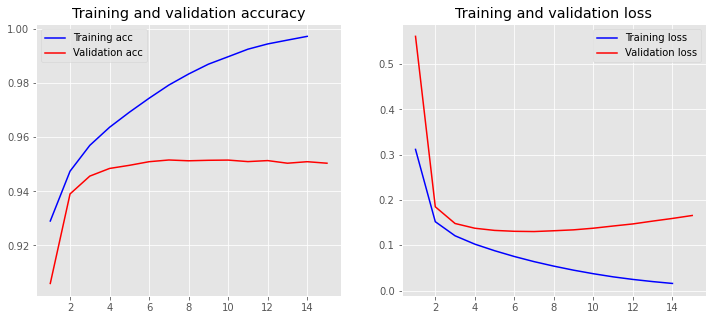

In [15]:
plt.style.use('ggplot')

h0 = history
plot_history(h0, name = 'hcnn0')

In [13]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9985
Testing Accuracy:  0.9504


Assess the classifier

In [16]:
test_predicted_prob0 = model.predict(X_test0)
test_predicted_classes0 = test_predicted_prob0.argmax(1)

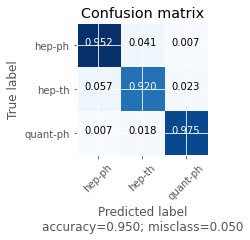

In [19]:
#Confusion matrix
conf = confusion_matrix(encoded_y_test0, test_predicted_classes0)
le_name_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
class_codes = [le_name_mapping[i] for i in range(3)]
plot_confusion_matrix(conf, class_codes, name = 'cnn0')

Set 1

In [ ]:
print(dataset1['category'].value_counts())

stat       19868
math-ph    17597
nucl-th    13730
q-bio      13316
hep-ex     10158
Name: category, dtype: int64


Split the dataset in training and test set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(dataset1["clean_text"], dataset1["category"], random_state = 1000,
                                                    stratify = dataset1["category"], test_size=0.2, shuffle=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = np.array([len(a) for a in X_train]).max()

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

dummy_y_train = to_categorical(encoded_y_train)
dummy_y_test = to_categorical(encoded_y_test)

X_train1 = X_train
dummy_y_train1 = dummy_y_train
X_test1 = X_test
dummy_y_test1 = dummy_y_test
encoded_y_test1 = encoded_y_test

model = KerasClassifier(build_fn=create_cnn_model, epochs=25, verbose=0, nclass=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Hp tuning through cv

In [ ]:
#1 conv layer

param_grid = dict(batch_size=cand_bs, embedding_dim=cand_ed, n_filters=cand_nf, k_size=cand_ks, nlayers=cand_nl[:1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results0 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#3 conv layers

param_grid = dict(batch_size=cand_bs, embedding_dim=cand_ed, n_filters=cand_nf, k_size=cand_ks, nlayers=cand_nl[1:2])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results1 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#5 conv layers

param_grid = dict(batch_size=cand_bs, embedding_dim=cand_ed, n_filters=cand_nf, k_size=cand_ks, nlayers=cand_nl[2:3])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results2 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

Summary of results of cv

In [ ]:
cv_results = pd.concat([cv_results0, cv_results1, cv_results2]).sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)

emb_cv_results1 = cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                              'split2_test_score', 'split3_test_score', 'split4_test_score'], 1)
clist = list(emb_cv_results1.columns.values)
cv_results_set1_emb = emb_cv_results1[clist[-2:] + clist[:-2]]
cv_results_set1_emb

In [ ]:
cv_results_set1_emb.to_csv('cv_results_set1_emb.csv', encoding = 'utf-8-sig') 
files.download('cv_results_set1_emb.csv')


Train the neural network with tuned hyperparameters on the whole training set

In [32]:
clear_session()
model = create_cnn_model(embedding_dim=50, n_filters=32, k_size=3, nlayers=1, nclass=5)
model.summary()

Model: "Convolutional_Neural_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 484, 50)           3072050   
                                                                 
 primo (Conv1D)              (None, 482, 32)           4832      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 3,077,267
Trainable params: 3,077,267
Non-trainable params: 0
____________________________

In [33]:
h1 = model.fit(X_train, dummy_y_train, epochs=30, verbose=True, validation_data=(X_test, dummy_y_test), batch_size=2048)

Epoch 1/30
30/30 [==============================] - 50s 2s/step - loss: 1.5346 - accuracy: 0.3495 - val_loss: 1.4282 - val_accuracy: 0.4696
Epoch 2/30
30/30 [==============================] - 41s 1s/step - loss: 1.2760 - accuracy: 0.4968 - val_loss: 1.1089 - val_accuracy: 0.5294
Epoch 3/30
30/30 [==============================] - 40s 1s/step - loss: 0.9675 - accuracy: 0.5731 - val_loss: 0.8566 - val_accuracy: 0.6128
Epoch 4/30
30/30 [==============================] - 40s 1s/step - loss: 0.7377 - accuracy: 0.6533 - val_loss: 0.6436 - val_accuracy: 0.7251
Epoch 5/30
30/30 [==============================] - 41s 1s/step - loss: 0.4929 - accuracy: 0.8659 - val_loss: 0.4010 - val_accuracy: 0.9145
Epoch 6/30
30/30 [==============================] - 40s 1s/step - loss: 0.2784 - accuracy: 0.9440 - val_loss: 0.2530 - val_accuracy: 0.9358
Epoch 7/30
30/30 [==============================] - 41s 1s/step - loss: 0.1682 - accuracy: 0.9583 - val_loss: 0.1978 - val_accuracy: 0.9409
Epoch 8/30
30/30 [==

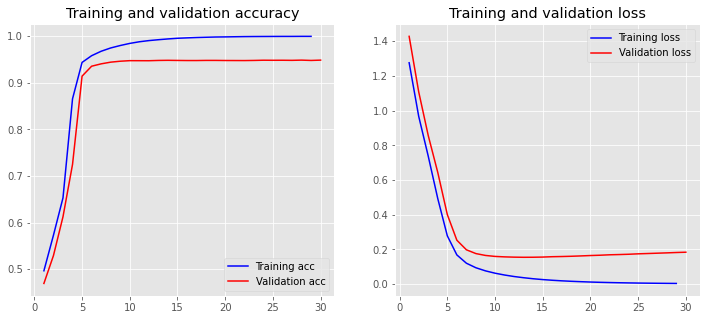

In [34]:
plt.style.use('ggplot')

plot_history(h1, name = 'hcnn1')

In [35]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.3f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.3f}".format(accuracy))

Training Accuracy: 1.000
Testing Accuracy:  0.949


Assess the classifier

In [36]:
test_predicted_prob1 = model.predict(X_test1)
test_predicted_classes1 = test_predicted_prob1.argmax(1)

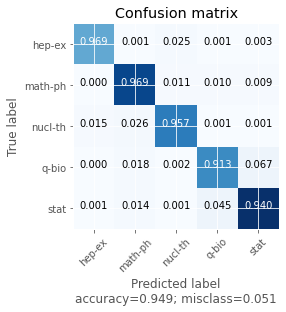

In [37]:
#Confusion matrix
conf = confusion_matrix(encoded_y_test1, test_predicted_classes1)
le_name_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
class_codes = [le_name_mapping[i] for i in range(5)]
plot_confusion_matrix(conf, class_codes, name = 'cnn1', xsize=6, ysize=4)